# GmGM

This notebook is a minimal example of how to use GmGM.  We have not worked on the analysis of this dataset; we have merely run our algorithm on it and presented it as-is.

Here's how to install all dependencies:
```bash
# Create environment
conda create -n {YOUR ENVIRONMENT NAME} "conda-forge::python>=3.9,<3.12"
conda activate {YOUR ENVIRONMENT NAME}

# Install GmGM
pip install gmgm

# Install this example notebook's dependencies
conda install conda-forge::scanpy
conda install conda-forge::leidenalg
```

In [1]:
# Import GmGM
from GmGM import GmGM, Dataset

# Dask is a dependency of GmGM
import dask.array as da

In [2]:
# Import scanpy/anndata to show use in omics context
# These are not dependencies of the GmGM package
import scanpy as sc
import anndata as ad

In [3]:
# scanpy often raises NumbaDeprecation warnings and other warnings not relevant to the user
import warnings
warnings.filterwarnings(action='ignore', module='umap')
warnings.filterwarnings(action='ignore', module='tqdm')
warnings.filterwarnings(action='ignore', module='scanpy')

In [4]:
# Some parameters to play with
N_COMPONENTS = 50
N_NEIGHBORS = 10
RANDOM_STATE = 0

In [5]:
# A helper function to plot multiple embeddings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # just for typing
from typing import Optional

def many_embeddings(
    adata: ad.AnnData,
    embeddings: list[str],
    return_fig: bool = False,
    **kwargs
) -> Optional[tuple[plt.Figure, np.ndarray[plt.Axes]]]:
    kwargs = kwargs.copy()

    # Create plot
    fig, axs = plt.subplots(
        figsize=(10, 5),
        ncols=2 if len(embeddings) > 1 else 1,
        nrows=len(embeddings) // 2
    )

    # Input handling
    if 'palette' not in kwargs:
        kwargs['palette'] = 'tab20'
    if 'projection' not in kwargs:
        kwargs['projection'] = '2d'
    if 'legend_loc' not in kwargs:
        kwargs['legend_loc'] = 'on data'
    if 'na_in_legend' not in kwargs:
        kwargs['na_in_legend'] = False

    legend_loc = kwargs['legend_loc']
    del kwargs['legend_loc']

    for idx, (ax, basis) in enumerate(zip(axs.flat, embeddings)):
        _legend_loc = legend_loc
        if legend_loc == 'right margin' and idx % 2 == 0:
            # Only show every second legend
            _legend_loc = None
        sc.pl.embedding(
            adata,
            basis=basis,
            ax=ax,
            show=False,
            legend_loc=_legend_loc,
            **kwargs
        )
        ax.set_title(basis)
    if return_fig:
        return fig, axs

# "Small" dataset

> Paul et al. (2015), Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors

This dataset is small (<3000 cells, <3500 genes) so it makes a good first example.

In [6]:
paul15 = sc.datasets.paul15()
paul15.obs['paul15_clusters'] = paul15.obs['paul15_clusters'].astype('category')
sc.pp.log1p(paul15)
paul15

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot', 'log1p'

First let's just do some standard pca/umap plots.  We'll color by the pre-defined clusters of Paul et al.

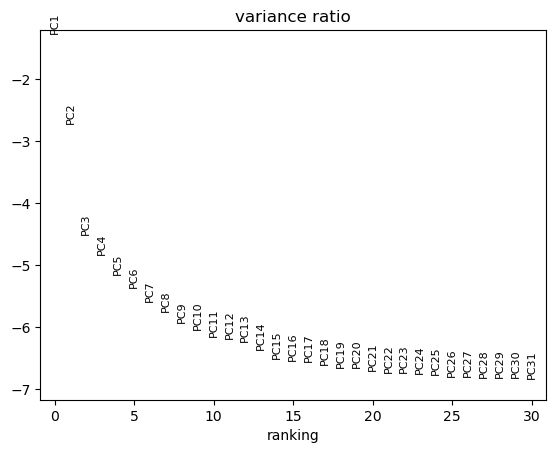

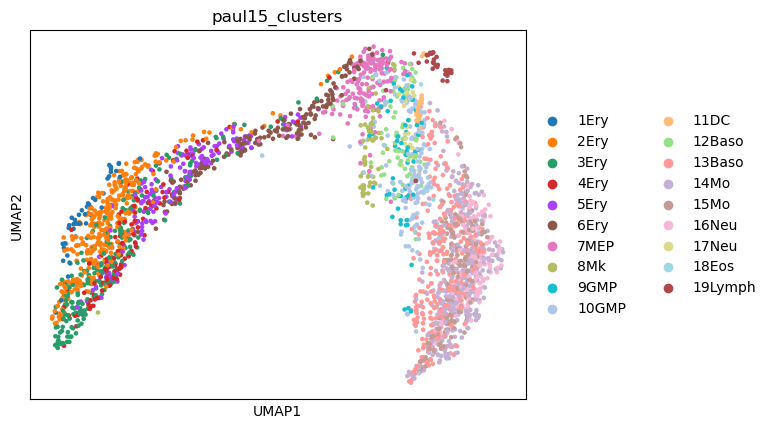

In [7]:
sc.pp.pca(paul15, n_comps=N_COMPONENTS, random_state=RANDOM_STATE)
sc.pl.pca_variance_ratio(paul15, log=True)
sc.pp.neighbors(paul15, n_neighbors=N_NEIGHBORS, random_state=RANDOM_STATE)
sc.tl.umap(paul15, random_state=RANDOM_STATE, n_components=3)
sc.pl.umap(paul15, color='paul15_clusters')

It seems like multiple clusters refer to the same cell type, so for simplicity we will combine these clusters!

In [8]:
# Create superclusters
paul15.obs['superclusters'] = "Ery"
paul15.obs["superclusters"] = paul15.obs["superclusters"].astype("category").cat.set_categories(
    [
        "Ery",
        "MEP",
        "Mk",
        "GMP",
        "DC",
        "Baso",
        "Mo",
        "Neu",
        "Eos",
        "Lymph"
    ]
)
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["7MEP"])] = "MEP"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["8Mk"])] = "Mk"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["9GMP", "10GMP"])] = "GMP"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["11DC"])] = "DC"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["12Baso", "13Baso"])] = "Baso"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["14Mo", "15Mo"])] = "Mo"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["16Neu", "17Neu"])] = "Neu"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["18Eos"])] = "Eos"
paul15.obs["superclusters"][paul15.obs["paul15_clusters"].isin(["19Lymph"])] = "Lymph"

Now we will run the GmGM algorithm.

For now, you have to specify the algorithm piece-by-piece.

In [9]:
GmGM(
    paul15,
    random_state=RANDOM_STATE,
    to_keep=N_NEIGHBORS,
    threshold_method='rowwise-col-weighted',
    print_memory_usage=True,
    key_map={"obs": "cell", "var": "gene"},
    key_added="gmgm_1"
)
paul15

Memory Usage: 
Dataset: 0.04 GB
Auxiliary: 0.15 GB
Output: 0.00 GB


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'superclusters'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'umap', 'paul15_clusters_colors', 'cell_neighbors_gmgm_1', 'gene_neighbors_gmgm_1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'cell_gmgm_1_connectivities'
    varp: 'gene_gmgm_1_connectivities'

UMAP works by first being given a graph, then computing an embedding.  We've already created a UMAP plot earlier, which by default uses the KNN embedding.  We can use GmGM's outputs as an embedding too!

In [10]:
# Save the UMAP embedding
paul15.obsm['X_umap_knn'] = paul15.obsm['X_umap'].copy()

# Save the gmgm UMAP embedding
sc.tl.umap(paul15, neighbors_key='cell_neighbors_gmgm_1', n_components=3, random_state=RANDOM_STATE)
paul15.obsm['X_umap_gmgm_1'] = paul15.obsm['X_umap'].copy()

To understand properties of our gram, we can look at an example clustering of it!

In [11]:
# leidenalg is an optional dependency of scanpy - this will give an error if you have not installed it!
# Thankfully the error it throws will give you install directions ;)
sc.tl.leiden(paul15, neighbors_key='cell_neighbors_gmgm_1', key_added='leiden_gmgm_1', random_state=RANDOM_STATE)
sc.tl.leiden(paul15, neighbors_key='neighbors', key_added='leiden_knn', random_state=RANDOM_STATE)

A confusion plot of our clustering versus the annotated cell types reveal that we most of our clusters are decently precise, with the exception of cluster 0.

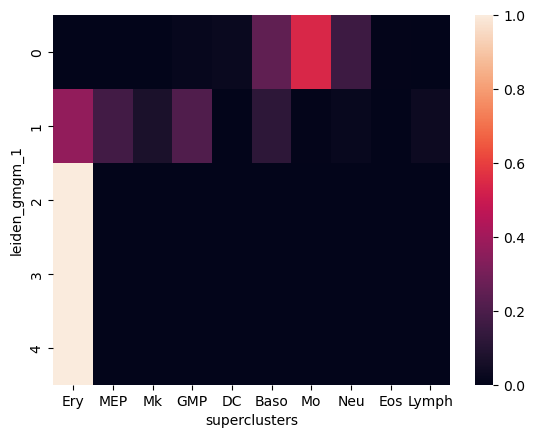

In [12]:
cmtx = sc.metrics.confusion_matrix(
    paul15.obs['leiden_gmgm_1'],
    paul15.obs['superclusters'],
)
sns.heatmap(cmtx, annot=False)
pass

KNN clusters seem to do similarly.

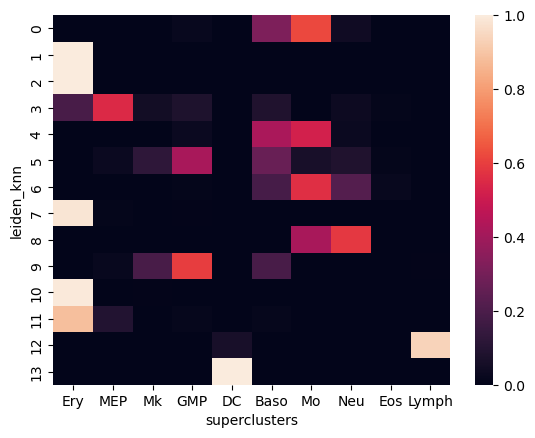

In [13]:
cmtx = sc.metrics.confusion_matrix(
    paul15.obs['leiden_knn'],
    paul15.obs['superclusters'],
)
sns.heatmap(cmtx, annot=False)
pass

If we plot these, we can see why - GmGM has tended to split off the end points of development into their own separate blobs.

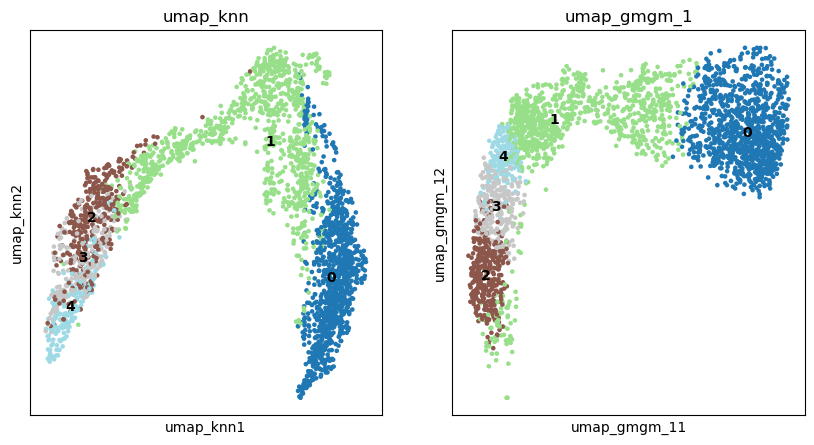

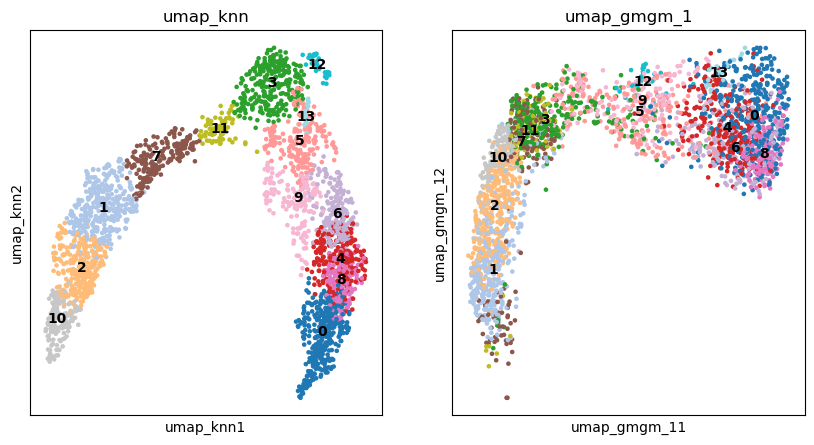

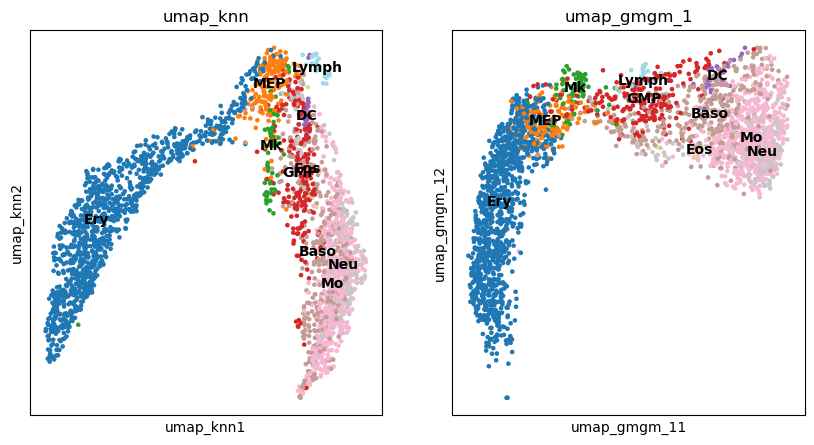

In [14]:
many_embeddings(
    paul15,
    embeddings=['umap_knn','umap_gmgm_1'],
    color='leiden_gmgm_1',
    palette="tab20",
    legend_loc='on data',
)
many_embeddings(
    paul15,
    embeddings=['umap_knn','umap_gmgm_1'],
    color='leiden_knn',
    palette="tab20",
    legend_loc='on data',
)
many_embeddings(
    paul15,
    embeddings=['umap_knn','umap_gmgm_1'],
    color='superclusters',
    palette="tab20",
    legend_loc='on data',
)

# Approximation GmGM

The algorithm used above requires quadratic memory.  When we only have a single matrix input, as in our case, we can forgo the use of `grammify` and thus have a linear-memory approximation (provided we only use a finite amount of principal components).

In [38]:
GmGM(
    paul15,
    random_state=RANDOM_STATE,
    n_comps=N_COMPONENTS,
    to_keep=N_NEIGHBORS,
    threshold_method='rowwise-col-weighted',
    print_memory_usage=True,
    key_map={"obs": "cell", "var": "gene"},
    key_added="gmgm_2",
    readonly=True
)

/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/core.py:381: RuntimeWarning: invalid value encountered in scalar divide
  if err_diff/np.abs(err) < tol or line_search_gave_up:


Memory Usage: 
Dataset: 0.04 GB
Auxiliary: 0.00 GB
Output: 0.00 GB


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'superclusters', 'leiden_gmgm_1', 'leiden_knn', 'leiden_gmgm_2', 'leiden_gmgm_3'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'umap', 'paul15_clusters_colors', 'cell_neighbors_gmgm_1', 'gene_neighbors_gmgm_1', 'leiden', 'leiden_gmgm_1_colors', 'leiden_knn_colors', 'superclusters_colors', 'cell_neighbors_gmgm_2', 'gene_neighbors_gmgm_2', 'leiden_gmgm_2_colors', 'cell_neighbors_gmgm_3', 'gene_neighbors_gmgm_3', 'leiden_gmgm_3_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_knn', 'X_umap_gmgm_1', 'X_umap_gmgm_2', 'X_umap_gmgm_3'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'cell_gmgm_1_connectivities', 'cell_gmgm_2_connectivities', 'cell_gmgm_3_connectivities'
    varp: 'gene_gmgm_1_connectivities', 'gene_gmgm_2_connectivities', 'gene_gmgm_3_connectivities'

In [39]:
# Save the gmgm UMAP embedding
sc.tl.umap(paul15, neighbors_key='cell_neighbors_gmgm_2', n_components=3, random_state=RANDOM_STATE)
paul15.obsm['X_umap_gmgm_2'] = paul15.obsm['X_umap'].copy()

In [40]:
sc.tl.leiden(paul15, neighbors_key='cell_neighbors_gmgm_2', key_added='leiden_gmgm_2', random_state=RANDOM_STATE)

TODO: Figure out why this is doing poorly!

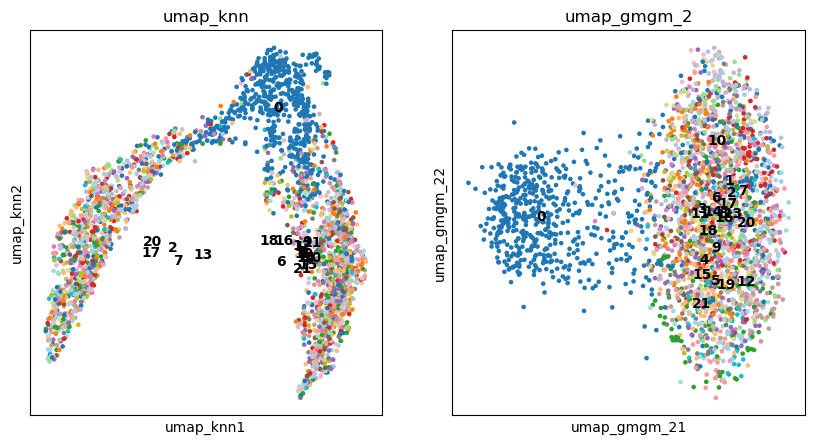

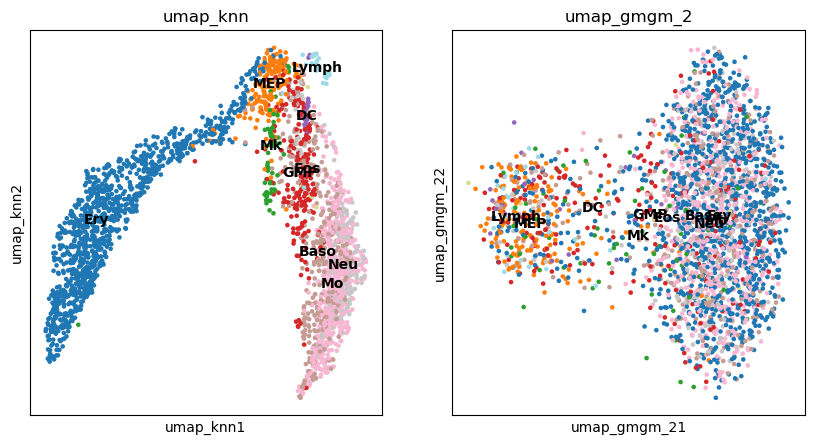

In [41]:
many_embeddings(
    paul15,
    embeddings=['umap_knn', 'umap_gmgm_2'],
    color='leiden_gmgm_2',
    palette="tab20",
    legend_loc='on data',
)
many_embeddings(
    paul15,
    embeddings=['umap_knn', 'umap_gmgm_2'],
    color='superclusters',
    palette="tab20",
    legend_loc='on data',
)

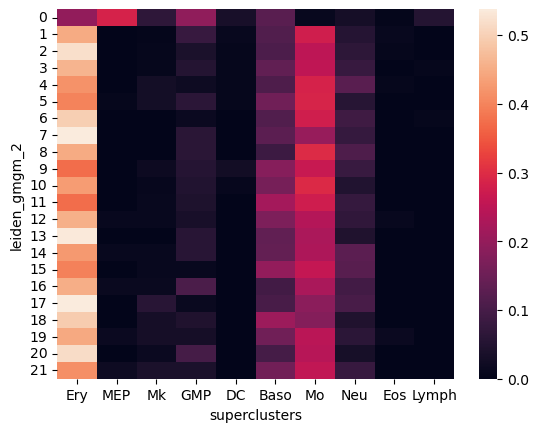

In [42]:
cmtx = sc.metrics.confusion_matrix(
    paul15.obs['leiden_gmgm_2'],
    paul15.obs['superclusters'],
)
sns.heatmap(cmtx, annot=False)
pass

KNN is broadly similar but seems to do a better job than the approximate GmGM at recreating the clusters found by Paul et al.

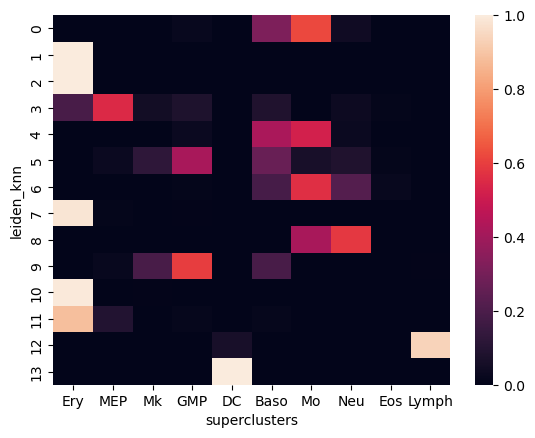

In [43]:
cmtx = sc.metrics.confusion_matrix(
    paul15.obs['leiden_knn'],
    paul15.obs['superclusters'],
)
sns.heatmap(cmtx, annot=False)
pass

# Nonparanormal skeptic

What if we use the nonparanormal skeptic?  This is a method to gaussianize the data.

It seems to perform poorly (although from prior work and our own experiments on other datasets we know it can perform well).  This could just be an error in our nonparanormal skeptic implementation, so consider this a prototype for now.

In [44]:
GmGM(
    paul15,
    use_nonparanormal_skeptic=True,
    random_state=RANDOM_STATE,
    to_keep=N_NEIGHBORS,
    threshold_method='rowwise-col-weighted',
    batch_size=1000,
    print_memory_usage=True,
    key_map={"obs": "cell", "var": "gene"},
    key_added="gmgm_3"
)

Memory Usage: 
Dataset: 0.04 GB
Auxiliary: 0.31 GB
Output: 0.00 GB


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'superclusters', 'leiden_gmgm_1', 'leiden_knn', 'leiden_gmgm_2', 'leiden_gmgm_3'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'umap', 'paul15_clusters_colors', 'cell_neighbors_gmgm_1', 'gene_neighbors_gmgm_1', 'leiden', 'leiden_gmgm_1_colors', 'leiden_knn_colors', 'superclusters_colors', 'cell_neighbors_gmgm_2', 'gene_neighbors_gmgm_2', 'leiden_gmgm_2_colors', 'cell_neighbors_gmgm_3', 'gene_neighbors_gmgm_3', 'leiden_gmgm_3_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_knn', 'X_umap_gmgm_1', 'X_umap_gmgm_2', 'X_umap_gmgm_3'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'cell_gmgm_1_connectivities', 'cell_gmgm_2_connectivities', 'cell_gmgm_3_connectivities'
    varp: 'gene_gmgm_1_connectivities', 'gene_gmgm_2_connectivities', 'gene_gmgm_3_connectivities'

In [45]:
# Save the gmgm UMAP embedding
sc.tl.umap(paul15, neighbors_key='cell_neighbors_gmgm_3', n_components=3, random_state=RANDOM_STATE)
paul15.obsm['X_umap_gmgm_3'] = paul15.obsm['X_umap'].copy()

In [46]:
sc.tl.leiden(paul15, neighbors_key='cell_neighbors_gmgm_3', key_added='leiden_gmgm_3', random_state=RANDOM_STATE)

The nonparanormal skeptic did "too good" a job at gaussianizing it!  It just became a blob.

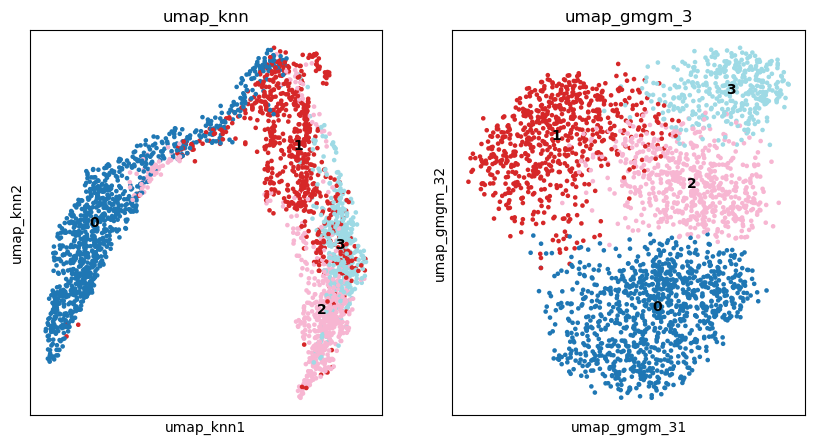

In [47]:
many_embeddings(
    paul15,
    embeddings=['umap_knn', 'umap_gmgm_3'],
    color='leiden_gmgm_3',
    palette="tab20",
    legend_loc='on data',
)

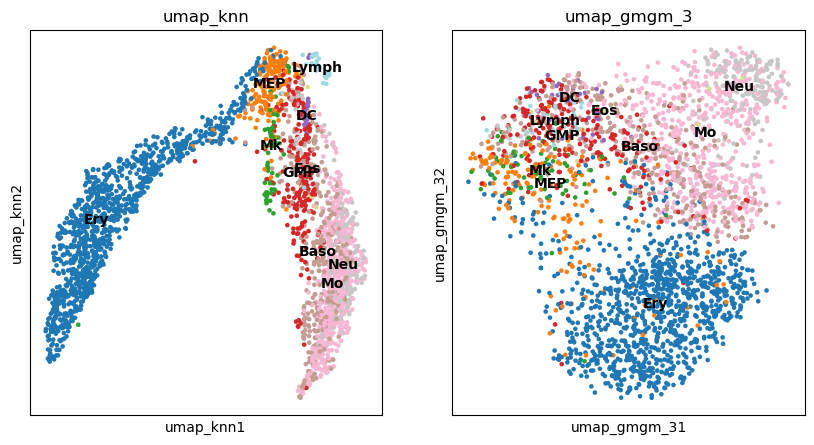

In [48]:
many_embeddings(
    paul15,
    embeddings=['umap_knn', 'umap_gmgm_3'],
    color='superclusters',
    palette="tab20",
    legend_loc='on data',
)

Let's try again without the log transform.  In theory it should perform the same, as log is a monotonic transformation and the Nonparanormal Skeptic is invariant to these.  In practice, the results are different...

In [49]:
paul15_nolog = paul15.copy()
paul15_nolog.X = sc.datasets.paul15().X

In [50]:
GmGM(
    paul15_nolog,
    use_nonparanormal_skeptic=True,
    random_state=RANDOM_STATE,
    to_keep=N_NEIGHBORS,
    threshold_method='rowwise-col-weighted',
    batch_size=1000,
    print_memory_usage=True,
    key_map={"obs": "cell", "var": "gene"},
    key_added="gmgm_4"
)

Memory Usage: 
Dataset: 0.04 GB
Auxiliary: 0.31 GB
Output: 0.00 GB


AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters', 'superclusters', 'leiden_gmgm_1', 'leiden_knn', 'leiden_gmgm_2', 'leiden_gmgm_3'
    uns: 'iroot', 'log1p', 'pca', 'neighbors', 'umap', 'paul15_clusters_colors', 'cell_neighbors_gmgm_1', 'gene_neighbors_gmgm_1', 'leiden', 'leiden_gmgm_1_colors', 'leiden_knn_colors', 'superclusters_colors', 'cell_neighbors_gmgm_2', 'gene_neighbors_gmgm_2', 'leiden_gmgm_2_colors', 'cell_neighbors_gmgm_3', 'gene_neighbors_gmgm_3', 'leiden_gmgm_3_colors', 'cell_neighbors_gmgm_4', 'gene_neighbors_gmgm_4'
    obsm: 'X_pca', 'X_umap', 'X_umap_knn', 'X_umap_gmgm_1', 'X_umap_gmgm_2', 'X_umap_gmgm_3'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'cell_gmgm_1_connectivities', 'cell_gmgm_2_connectivities', 'cell_gmgm_3_connectivities', 'cell_gmgm_4_connectivities'
    varp: 'gene_gmgm_1_connectivities', 'gene_gmgm_2_connectivities', 'gene_gmgm_3_connectivities', 'gene_gmgm_4_connectivities'

In [51]:
# Save the gmgm UMAP embedding
sc.tl.umap(paul15_nolog, neighbors_key='cell_neighbors_gmgm_4', n_components=3, random_state=RANDOM_STATE)
paul15_nolog.obsm['X_umap_gmgm_4'] = paul15_nolog.obsm['X_umap'].copy()

In [52]:
sc.tl.leiden(paul15_nolog, neighbors_key='cell_neighbors_gmgm_4', key_added='leiden_gmgm_4', random_state=RANDOM_STATE)

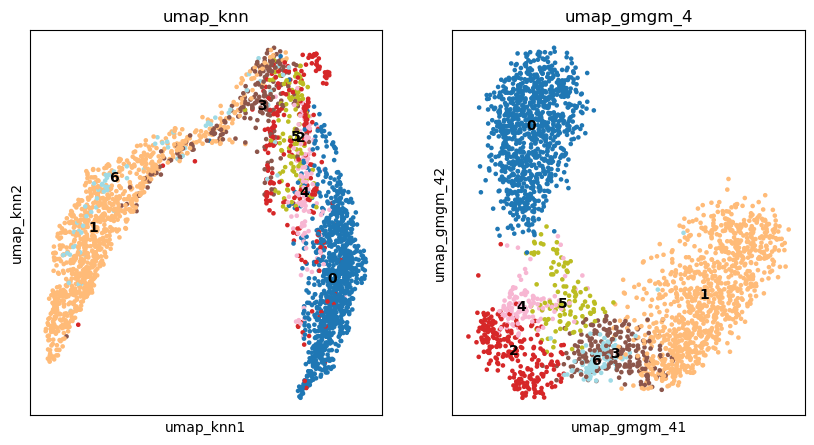

In [53]:
many_embeddings(
    paul15_nolog,
    embeddings=['umap_knn', 'umap_gmgm_4'],
    color='leiden_gmgm_4',
    palette="tab20",
    legend_loc='on data',
)

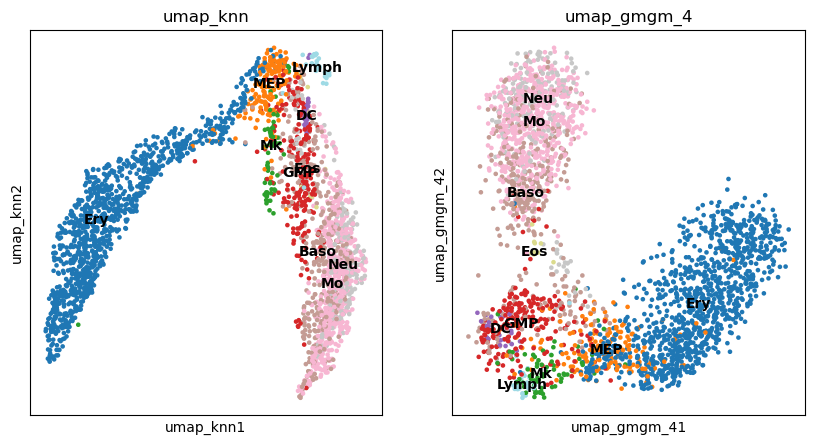

In [54]:
many_embeddings(
    paul15_nolog,
    embeddings=['umap_knn', 'umap_gmgm_4'],
    color='superclusters',
    palette="tab20",
    legend_loc='on data',
)

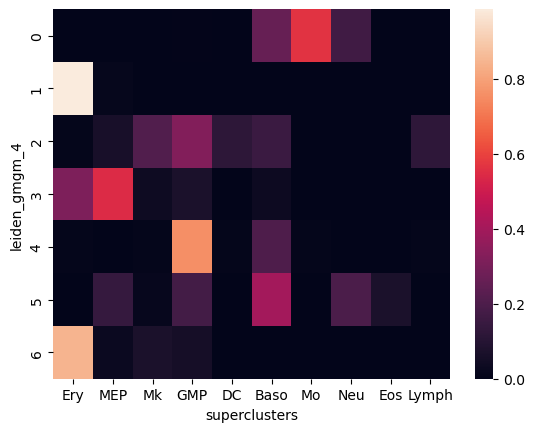

In [55]:
cmtx = sc.metrics.confusion_matrix(
    paul15_nolog.obs['leiden_gmgm_4'],
    paul15_nolog.obs['superclusters'],
)
sns.heatmap(cmtx, annot=False)
pass

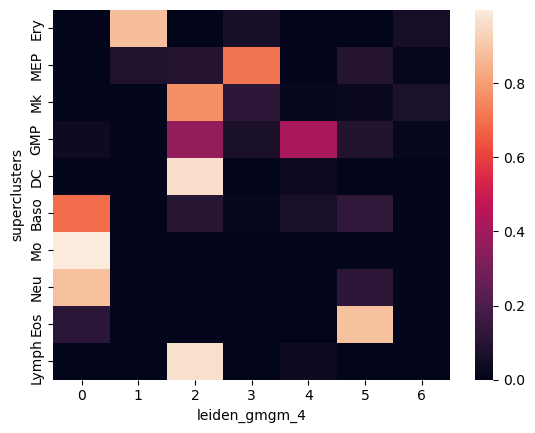

In [56]:
cmtx = sc.metrics.confusion_matrix(
    paul15_nolog.obs['superclusters'],
    paul15_nolog.obs['leiden_gmgm_4'],
)
sns.heatmap(cmtx, annot=False)
pass